Produisez une étude de marché avec R ou Python

# 1 - Importation des librairies et des Datas

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
import scipy.cluster.hierarchy as sch
from sklearn import metrics
from sklearn import decomposition
from sklearn import preprocessing


In [3]:
data = pd.read_csv('C:/Users/benmi/Documents/Data Analyst/P_9/FAOSTAT_data.csv')
pop = pd.read_csv('C:/Users/benmi/Documents/Data Analyst/P_9/FAOSTAT_data_pop.csv') 
pib = pd.read_csv('C:/Users/benmi/Documents/Data Analyst/P_9/FAOSTAT_PIB_hab2017.csv') 
stab = pd.read_csv('C:/Users/benmi/Documents/Data Analyst/P_9/FAOSTAT_stabilité_pol2017.csv') 

In [4]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [5]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

# Exploration des datas

In [6]:
data.head(11)

,Domain Code,Domain,Area Code (ISO3),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FBS,Food Balances (2010-),AFG,Afghanistan,5511,Production,2734,Poultry Meat,2017,2017,1000 tonnes,28.00,Im,FAO data based on imputation methodology
1,FBS,Food Balances (2010-),AFG,Afghanistan,5611,Import Quantity,2734,Poultry Meat,2017,2017,1000 tonnes,29.00,Im,FAO data based on imputation methodology
2,FBS,Food Balances (2010-),AFG,Afghanistan,5072,Stock Variation,2734,Poultry Meat,2017,2017,1000 tonnes,-7.00,Im,FAO data based on imputation methodology
3,FBS,Food Balances (2010-),AFG,Afghanistan,5301,Domestic supply quantity,2734,Poultry Meat,2017,2017,1000 tonnes,64.00,S,Standardized data
4,FBS,Food Balances (2010-),AFG,Afghanistan,5170,Residuals,2734,Poultry Meat,2017,2017,1000 tonnes,0.00,Im,FAO data based on imputation methodology
5,FBS,Food Balances (2010-),AFG,Afghanistan,5142,Food,2734,Poultry Meat,2017,2017,1000 tonnes,64.00,Im,FAO data based on imputation methodology
6,FBS,Food Balances (2010-),AFG,Afghanistan,645,Food supply quantity (kg/capita/yr),2734,Poultry Meat,2017,2017,kg,1.76,Fc,Calculated data
7,FBS,Food Balances (2010-),AFG,Afghanistan,664,Food supply (kcal/capita/day),2734,Poultry Meat,2017,2017,kcal/capita/day,6.00,Fc,Calculated data
8,FBS,Food Balances (2010-),AFG,Afghanistan,674,Protein supply quantity (g/capita/day),2734,Poultry Meat,2017,2017,g/capita/day,0.63,Fc,Calculated data
9,FBS,Food Balances (2010-),AFG,Afghanistan,684,Fat supply quantity (g/capita/day),2734,Poultry Meat,2017,2017,g/capita/day,0.38,Fc,Calculated data


In [7]:
pop.head()

,Domain Code,Domain,Area Code (ISO3),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,AFG,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,36296.113,X,International reliable sources,NaN
1,OA,Annual population,ALB,Albania,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,2884.169,X,International reliable sources,NaN
2,OA,Annual population,DZA,Algeria,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,41389.189,X,International reliable sources,NaN
3,OA,Annual population,ASM,American Samoa,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,55.620,X,International reliable sources,NaN
4,OA,Annual population,AND,Andorra,511,Total Population - Both sexes,3010,Population - Est. & Proj.,2017,2017,1000 persons,77.001,X,International reliable sources,NaN


In [8]:
pib.head(20)

,Domain Code,Domain,Area Code (ISO3),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,MK,Macro Indicators,AFG,Afghanistan,6119,Value US$ per capita,22008,Gross Domestic Product,2017,2017,US$,520.616409,X,International reliable sources,NaN
1,MK,Macro Indicators,ALB,Albania,6119,Value US$ per capita,22008,Gross Domestic Product,2017,2017,US$,4514.204908,X,International reliable sources,NaN
2,MK,Macro Indicators,DZA,Algeria,6119,Value US$ per capita,22008,Gross Domestic Product,2017,2017,US$,4109.696001,X,International reliable sources,NaN
3,MK,Macro Indicators,AND,Andorra,6119,Value US$ per capita,22008,Gross Domestic Product,2017,2017,US$,38962.613799,X,International reliable sources,NaN
4,MK,Macro Indicators,AGO,Angola,6119,Value US$ per capita,22008,Gross Domestic Product,2017,2017,US$,4095.811686,X,International reliable sources,NaN
5,MK,Macro Indicators,AIA,Anguilla,6119,Value US$ per capita,22008,Gross Domestic Product,2017,2017,US$,19271.499970,X,International reliable sources,NaN
6,MK,Macro Indicators,ATG,Antigua and Barbuda,6119,Value US$ per capita,22008,Gross Domestic Product,2017,2017,US$,15383.415188,X,International reliable sources,NaN
7,MK,Macro Indicators,ARG,Argentina,6119,Value US$ per capita,22008,Gross Domestic Product,2017,2017,US$,14648.845969,X,International reliable sources,NaN
8,MK,Macro Indicators,ARM,Armenia,6119,Value US$ per capita,22008,Gross Domestic Product,2017,2017,US$,3914.525246,X,International reliable sources,NaN
9,MK,Macro Indicators,ABW,Aruba,6119,Value US$ per capita,22008,Gross Domestic Product,2017,2017,US$,29349.412216,X,International reliable sources,NaN


In [9]:
stab.head()

,Domain Code,Domain,Area Code (ISO3),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,FS,Suite of Food Security Indicators,AFG,Afghanistan,6125,Value,21032,Political stability and absence of violence/te...,2017,2017,index,-2.80,X,International reliable sources,NaN
1,FS,Suite of Food Security Indicators,ALB,Albania,6125,Value,21032,Political stability and absence of violence/te...,2017,2017,index,0.38,X,International reliable sources,NaN
2,FS,Suite of Food Security Indicators,DZA,Algeria,6125,Value,21032,Political stability and absence of violence/te...,2017,2017,index,-0.92,X,International reliable sources,NaN
3,FS,Suite of Food Security Indicators,ASM,American Samoa,6125,Value,21032,Political stability and absence of violence/te...,2017,2017,index,1.22,X,International reliable sources,NaN
4,FS,Suite of Food Security Indicators,AND,Andorra,6125,Value,21032,Political stability and absence of violence/te...,2017,2017,index,1.42,X,International reliable sources,NaN


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083 entries, 0 to 2082
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       2083 non-null   object 
 1   Domain            2083 non-null   object 
 2   Area Code (ISO3)  2083 non-null   object 
 3   Area              2083 non-null   object 
 4   Element Code      2083 non-null   int64  
 5   Element           2083 non-null   object 
 6   Item Code         2083 non-null   int64  
 7   Item              2083 non-null   object 
 8   Year Code         2083 non-null   int64  
 9   Year              2083 non-null   int64  
 10  Unit              2083 non-null   object 
 11  Value             2081 non-null   float64
 12  Flag              2083 non-null   object 
 13  Flag Description  2083 non-null   object 
dtypes: float64(1), int64(4), object(9)
memory usage: 228.0+ KB


In [11]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       237 non-null    object 
 1   Domain            237 non-null    object 
 2   Area Code (ISO3)  237 non-null    object 
 3   Area              237 non-null    object 
 4   Element Code      237 non-null    int64  
 5   Element           237 non-null    object 
 6   Item Code         237 non-null    int64  
 7   Item              237 non-null    object 
 8   Year Code         237 non-null    int64  
 9   Year              237 non-null    int64  
 10  Unit              237 non-null    object 
 11  Value             237 non-null    float64
 12  Flag              237 non-null    object 
 13  Flag Description  237 non-null    object 
 14  Note              1 non-null      object 
dtypes: float64(1), int64(4), object(10)
memory usage: 27.9+ KB


In [12]:
stab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       197 non-null    object 
 1   Domain            197 non-null    object 
 2   Area Code (ISO3)  197 non-null    object 
 3   Area              197 non-null    object 
 4   Element Code      197 non-null    int64  
 5   Element           197 non-null    object 
 6   Item Code         197 non-null    int64  
 7   Item              197 non-null    object 
 8   Year Code         197 non-null    int64  
 9   Year              197 non-null    int64  
 10  Unit              197 non-null    object 
 11  Value             197 non-null    float64
 12  Flag              197 non-null    object 
 13  Flag Description  197 non-null    object 
 14  Note              0 non-null      float64
dtypes: float64(2), int64(4), object(9)
memory usage: 23.2+ KB


In [13]:
pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       211 non-null    object 
 1   Domain            211 non-null    object 
 2   Area Code (ISO3)  211 non-null    object 
 3   Area              211 non-null    object 
 4   Element Code      211 non-null    int64  
 5   Element           211 non-null    object 
 6   Item Code         211 non-null    int64  
 7   Item              211 non-null    object 
 8   Year Code         211 non-null    int64  
 9   Year              211 non-null    int64  
 10  Unit              211 non-null    object 
 11  Value             211 non-null    float64
 12  Flag              211 non-null    object 
 13  Flag Description  211 non-null    object 
 14  Note              0 non-null      float64
dtypes: float64(2), int64(4), object(9)
memory usage: 24.9+ KB


# Mise en conformité des données 

In [14]:
#On adapte les valeurs en fonction des unités

data["Value"] = data["Value"] * 1000
pop["Value"] = pop["Value"] * 1000
pd.options.display.float_format = '{:20.2f}'.format 

In [15]:
# On garde que les données qui nous intéresse;
data1 = data[["Area", "Element", "Value"]]
pop1 = pop[["Area", "Value"]]
pib1 = pib[["Area", "Value"]]
stab1 = stab[["Area", "Value"]]



In [16]:
data1 = pd.pivot_table(data1, index= 'Area', columns= ["Element"] , values=["Value"]).reset_index()
data1

Area                    Value  \
Element                                     Domestic supply quantity   
0                               Afghanistan                 64000.00   
1                                   Albania                 33000.00   
2                                   Algeria                286000.00   
3                                    Angola                318000.00   
4                       Antigua and Barbuda                  6000.00   
..                                      ...                      ...   
175      Venezuela (Bolivarian Republic of)                486000.00   
176                                Viet Nam                927000.00   
177                                   Yemen                253000.00   
178                                  Zambia                 60000.00   
179                                Zimbabwe                 75000.00   

                                                                 \
Element      Export Quantity Fat supply quantity (g/capita/day)   
0                        NaN                             380.00   
1                       0.00                            4460.00   
2                       0.00                            1630.00   
3                       0.00                            2240.00   
4                       0.00                           18630.00   
..                       ...                                ...   
175                      NaN                            3570.00   
176                  8000.00                            2590.00   
177                     0.00                            1970.00   
178                  1000.00                             750.00   
179                      NaN                            1110.00   

                                                            \
Element                 Food Food supply (kcal/capita/day)   
0                   64000.00                       6000.00   
1                   33000.00                      59000.00   
2                  286000.00                      24000.00   
3                  318000.00                      36000.00   
4                    5000.00                     247000.00   
..                       ...                           ...   
175                486000.00                      57000.00   
176                928000.00                      37000.00   
177                253000.00                      32000.00   
178                 60000.00                      12000.00   
179                 75000.00                      18000.00   

                                                                         \
Element Food supply quantity (kg/capita/yr)      Import Quantity Losses   
0                                   1760.00             29000.00    NaN   
1                                  11450.00             20000.00    NaN   
2                                   6910.00              2000.00    NaN   
3                                  10650.00            277000.00    NaN   
4                                  57310.00              7000.00    NaN   
..                                      ...                  ...    ...   
175                                16510.00             23000.00    NaN   
176                                 9810.00             62000.00    NaN   
177                                 9080.00             82000.00    NaN   
178                                 3580.00             12000.00    NaN   
179                                 5270.00              6000.00    NaN   

                                                               \
Element Other uses (non-food) Processing           Production   
0                         NaN        NaN             28000.00   
1                         NaN        NaN             13000.00   
2                         NaN        NaN            284000.00   
3                         NaN        NaN             40000.00   
4                        0.00        NaN                 

In [17]:
tableau = pd.merge(data1, pop1, on= ["Area"])
tableau1 = pd.merge(tableau, pib1, on= ["Area"])
tableau2 = pd.merge(tableau1, stab1, on= ["Area"])
tableau2.head()

C:\Users\benmi\AppData\Local\Temp/ipykernel_12228/3703410524.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  tableau = pd.merge(data1, pop1, on= ["Area"])


,Area,"(Area, )","(Value, Domestic supply quantity)","(Value, Export Quantity)","(Value, Fat supply quantity (g/capita/day))","(Value, Food)","(Value, Food supply (kcal/capita/day))","(Value, Food supply quantity (kg/capita/yr))","(Value, Import Quantity)","(Value, Losses)","(Value, Other uses (non-food))","(Value, Processing)","(Value, Production)","(Value, Protein supply quantity (g/capita/day))","(Value, Residuals)","(Value, Stock Variation)","(Value, Tourist consumption)",Value_x,Value_y,Value
0,Afghanistan,Afghanistan,64000.00,NaN,380.00,64000.00,6000.00,1760.00,29000.00,NaN,NaN,NaN,28000.00,630.00,0.00,-7000.00,NaN,36296113.00,520.62,-2.80
1,Albania,Albania,33000.00,0.00,4460.00,33000.00,59000.00,11450.00,20000.00,NaN,NaN,NaN,13000.00,4440.00,0.00,0.00,NaN,2884169.00,4514.20,0.38
2,Algeria,Algeria,286000.00,0.00,1630.00,286000.00,24000.00,6910.00,2000.00,NaN,NaN,NaN,284000.00,2130.00,0.00,0.00,NaN,41389189.00,4109.70,-0.92
3,Angola,Angola,318000.00,0.00,2240.00,318000.00,36000.00,10650.00,277000.00,NaN,NaN,NaN,40000.00,3630.00,0.00,0.00,NaN,29816766.00,4095.81,-0.33
4,Antigua and Barbuda,Antigua and Barbuda,6000.00,0.00,18630.00,5000.00,247000.00,57310.00,7000.00,NaN,0.00,NaN,0.00,18750.00,0.00,1000.00,0.00,95426.00,15383.42,0.75


In [18]:
tableau2.columns = ["Area", "Supr", "Domestic supply quantity", "Export Quantity", "Supr1", "Food", "Supr2", "Supr3", "Import Quantity", "Supr4", "Supr5", "Supr6", "Production", "Supr7", "Supr8", "Supr9", "Supr10" , "Population", "GPD per capita", "Stability Pol"]
tableau2 = tableau2.drop(columns=["Supr", "Supr1","Supr2","Supr3","Supr4","Supr5","Supr6","Supr7","Supr8","Supr9","Supr10"])


In [19]:
df_final = tableau2.fillna(0)

In [20]:
df_final.head()

,Area,Domestic supply quantity,Export Quantity,Food,Import Quantity,Production,Population,GPD per capita,Stability Pol
0,Afghanistan,64000.00,0.00,64000.00,29000.00,28000.00,36296113.00,520.62,-2.80
1,Albania,33000.00,0.00,33000.00,20000.00,13000.00,2884169.00,4514.20,0.38
2,Algeria,286000.00,0.00,286000.00,2000.00,284000.00,41389189.00,4109.70,-0.92
3,Angola,318000.00,0.00,318000.00,277000.00,40000.00,29816766.00,4095.81,-0.33
4,Antigua and Barbuda,6000.00,0.00,5000.00,7000.00,0.00,95426.00,15383.42,0.75


In [21]:
y = df_final['Area']

## NORMALISATION DES DONNEES / CENTRE - REDUITE

In [22]:
x = df_final.select_dtypes('number')
print('x', x.shape)

x (174, 8)


In [23]:
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(x)
X_scaled = pd.DataFrame(X_scaled, index=x.index, columns=x.columns)
print('X_scaled', X_scaled.shape)

X_scaled (174, 8)


In [24]:
# verif moyenne par colonne = 0 et verif ecart = 1
X_scaled.mean(axis=0), X_scaled.std(axis=0)

(Domestic supply quantity                  -0.00
 Export Quantity                           -0.00
 Food                                       0.00
 Import Quantity                            0.00
 Production                                 0.00
 Population                                -0.00
 GPD per capita                             0.00
 Stability Pol                              0.00
 dtype: float64,
 Domestic supply quantity                   1.00
 Export Quantity                            1.00
 Food                                       1.00
 Import Quantity                            1.00
 Production                                 1.00
 Population                                 1.00
 GPD per capita                             1.00
 Stability Pol                              1.00
 dtype: float64)

In [25]:
X_scaled.head()

,Domestic supply quantity,Export Quantity,Food,Import Quantity,Production,Population,GPD per capita,Stability Pol
0,-0.29,-0.22,-0.29,-0.30,-0.28,0.02,-0.68,-2.84
1,-0.31,-0.22,-0.31,-0.35,-0.29,-0.29,-0.47,0.52
2,-0.16,-0.22,-0.16,-0.45,-0.15,0.06,-0.49,-0.85
3,-0.15,-0.22,-0.14,1.07,-0.27,-0.04,-0.50,-0.23
4,-0.33,-0.22,-0.32,-0.42,-0.29,-0.31,0.09,0.91


Après observation des pays on constate 2 individus qui sortent du lot. En effet le Bresil et les Etats_Unis ont des valeurs très differentes du restes des autres individus à quel point que ces 2 pays créent une branche apparentiere dans le Dendrogramme. 
On peut les considérer comme outliers, de plus ils ne nous interessent pas car la quantité qu'ils importent est faible donc 
voilà pourquoi j'ai décidé de les écarter pour la suite de notre étude.

In [29]:
df_final.iloc[20]

Area                                     Brazil
Domestic supply quantity             9902000.00
Export Quantity                      4223000.00
Food                                 9902000.00
Import Quantity                         3000.00
Production                          14168000.00
Population                         207833823.00
GPD per capita                          9928.68
Stability Pol                             -0.42
Name: 20, dtype: object

In [30]:
df_final.iloc[165]

Area                        United States of America
Domestic supply quantity                 18305000.00
Export Quantity                           3692000.00
Food                                     18140000.00
Import Quantity                            123000.00
Production                               21914000.00
Population                              325084756.00
GPD per capita                              59921.67
Stability Pol                                   0.34
Name: 165, dtype: object

In [31]:
#Après observation du premier dendrogram, on observe 2 valeurs créant une nouvelle branche que l'on peut considerer comme outliers
# donc nous ferons sans ces 2 pays pour une étude plus juste

X_scaled.drop([20,165], axis=0, inplace=True)



In [32]:
df_final.drop(df_final.index[20], inplace=True)
df_final.drop(df_final.index[165], inplace=True)

# Dendrogramme

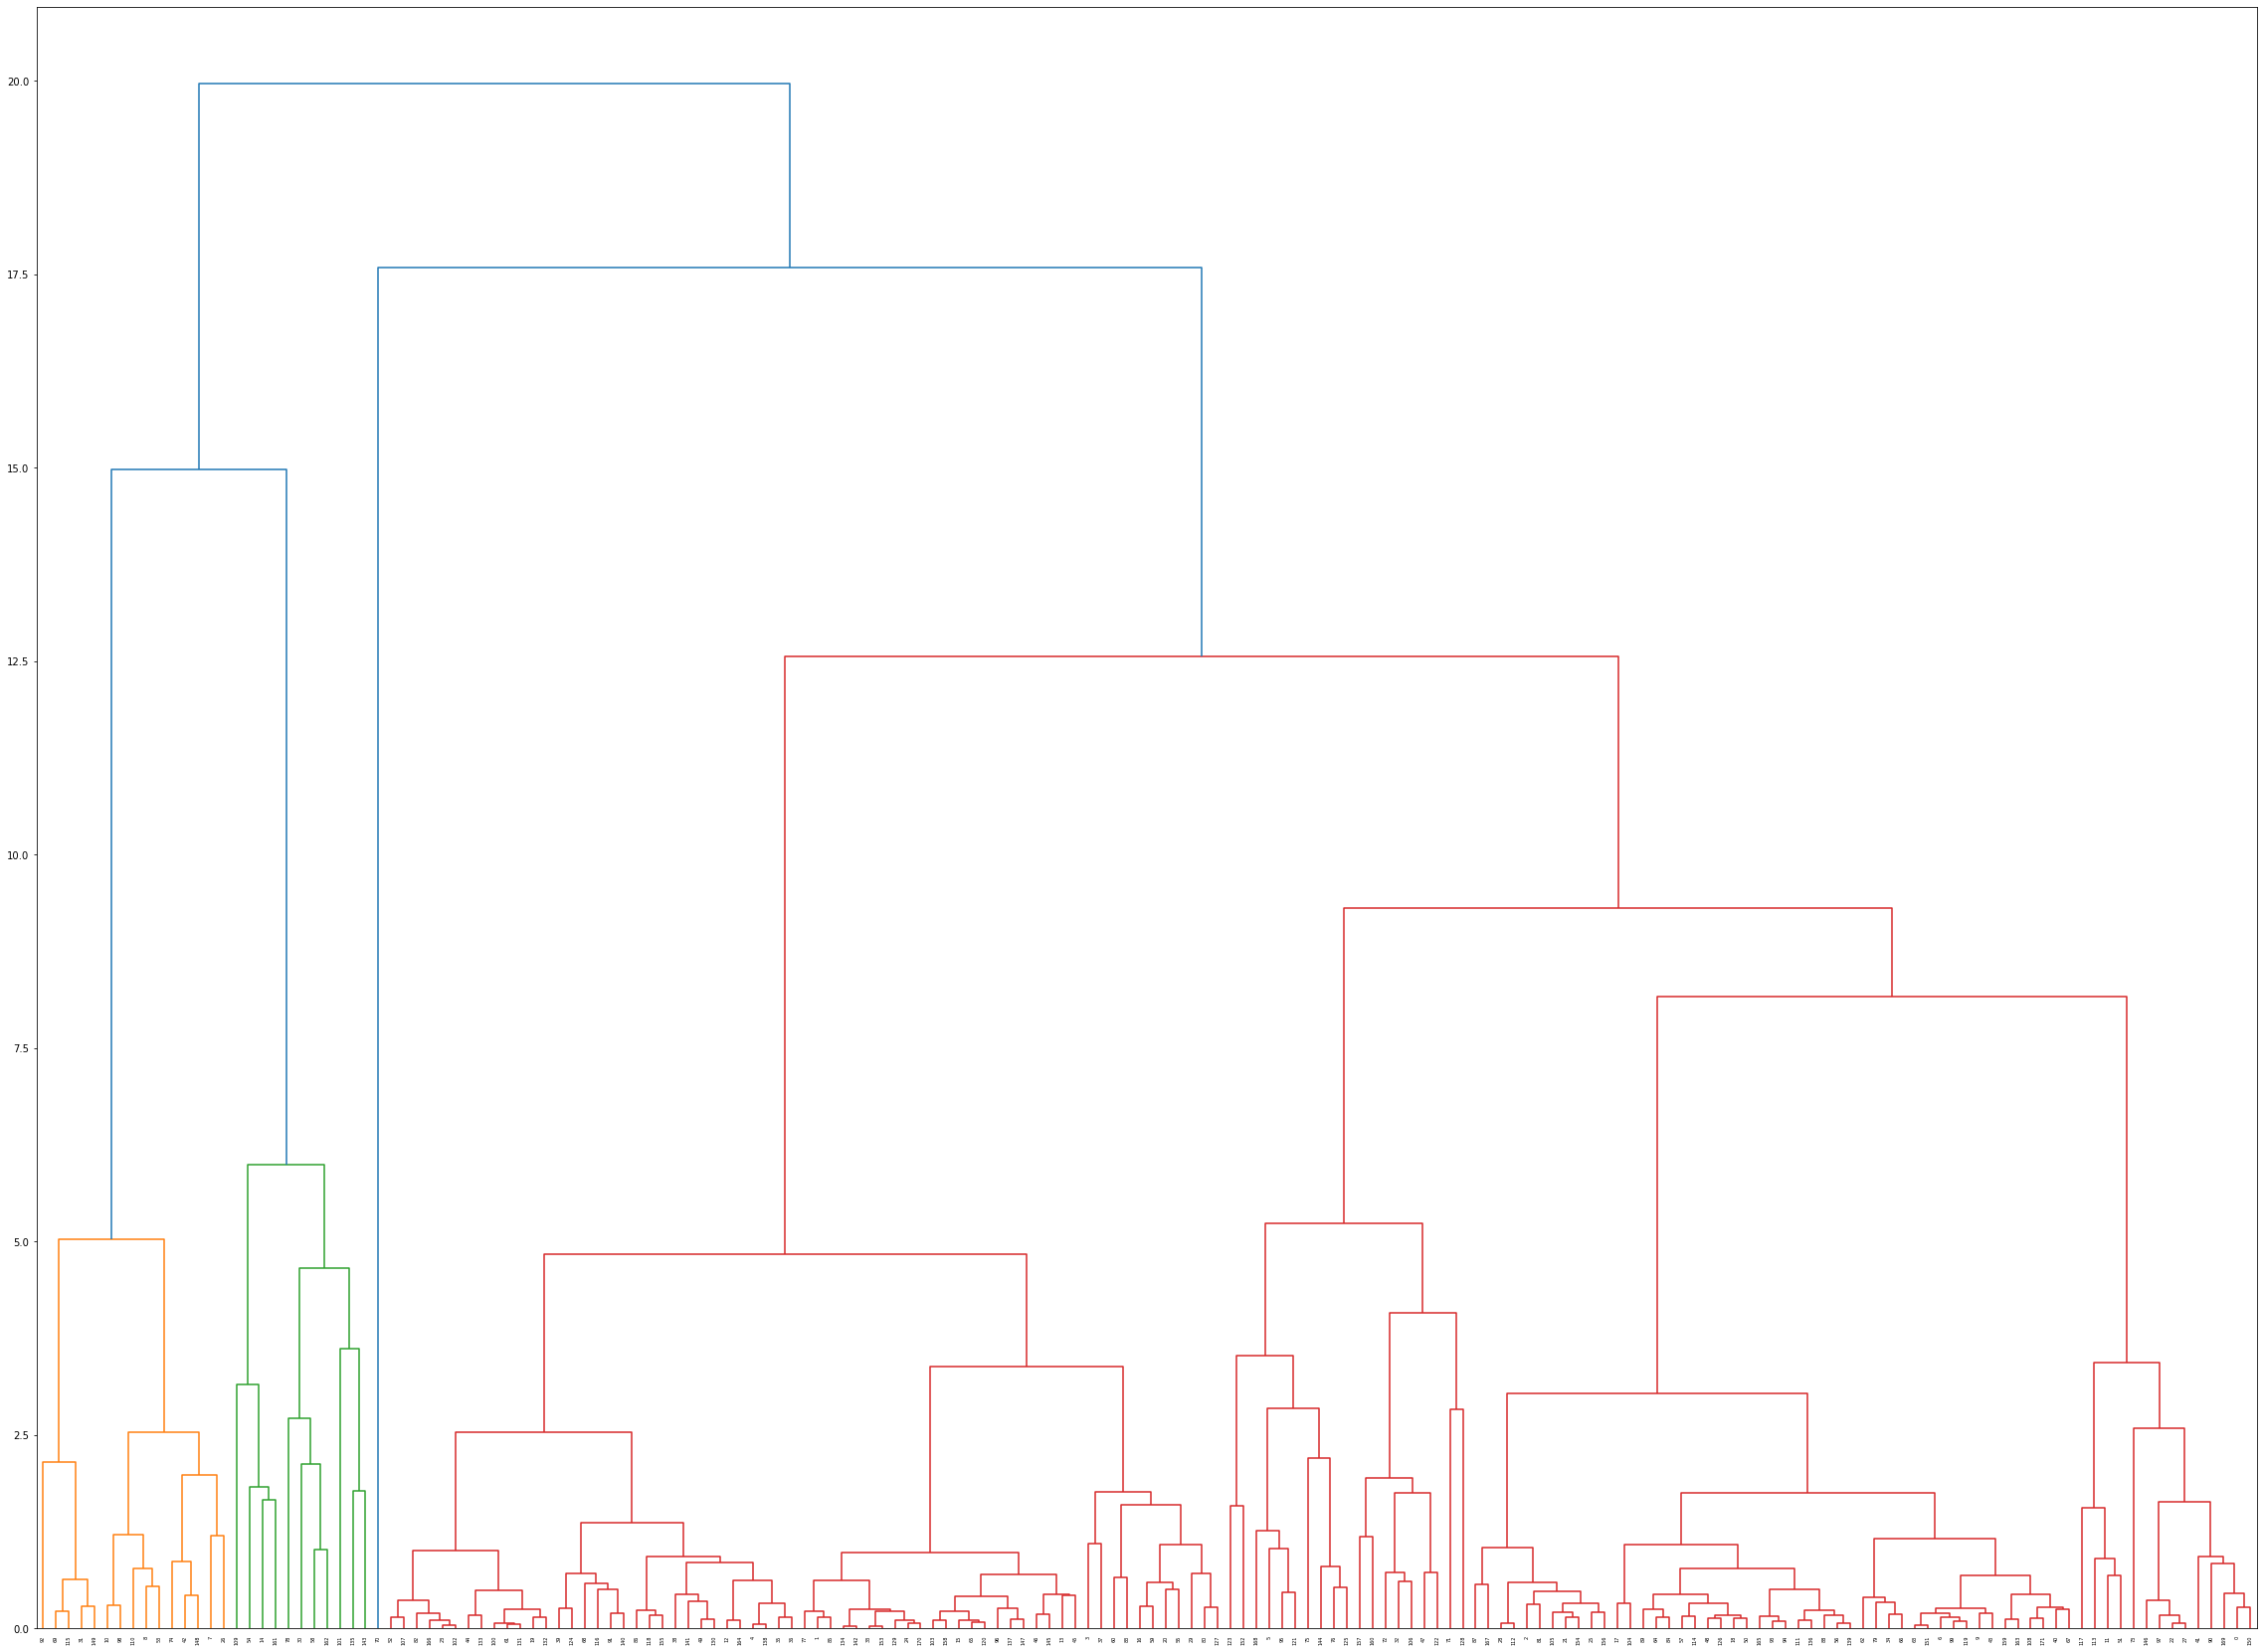

In [33]:
plt.figure(figsize=(40,30))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))

plt.show()

# Réalisation de l'ACP

In [34]:
from sklearn.decomposition import PCA

In [35]:
#define PCA model to use
pca = PCA()

#fit PCA model to data
X_reduced = pca.fit_transform(X_scaled)

In [36]:
x = X_scaled.select_dtypes('number')
print('x', x.shape)

x (172, 8)


In [37]:
pca_columns = ['PC'+ str(c) for c in range(1, X_reduced.shape[1]+1, 1)]
X_reduced = pd.DataFrame(X_reduced, index=x.index, columns=pca_columns)
X_reduced.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-2.34,0.36,-0.96,1.45,-0.31,0.01,0.00,0.00
1,-0.10,-0.68,0.14,-0.57,-0.07,-0.01,-0.00,-0.00
2,-1.05,-0.06,-0.06,0.30,-0.02,-0.01,-0.00,-0.00
3,-0.06,0.52,-0.87,-0.40,-0.50,-0.20,-0.02,0.00
4,0.48,-0.83,0.42,-0.40,-0.04,-0.04,-0.00,-0.00


In [38]:
pca.explained_variance_ratio_

array([3.65865141e-01, 3.03618981e-01, 1.70896044e-01, 8.99056460e-02,
       4.32396604e-02, 2.59606950e-02, 4.53954225e-04, 5.98780648e-05])

In [39]:
explained_variance = pd.Series(dict(zip(X_reduced.columns, 100.0*pca.explained_variance_ratio_)))

In [40]:
explained_variance.head()
# Bonne nouvelle ! On observe que les composantes PC1 + PC2 representent ensemble 66% du résultat ! c'est suffisant pour s'en servir

PC1                  36.59
PC2                  30.36
PC3                  17.09
PC4                   8.99
PC5                   4.32
dtype: float64

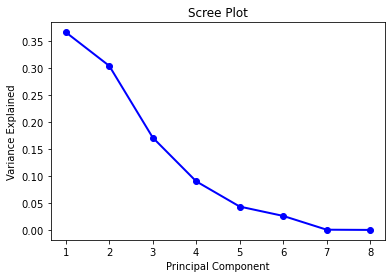

In [41]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

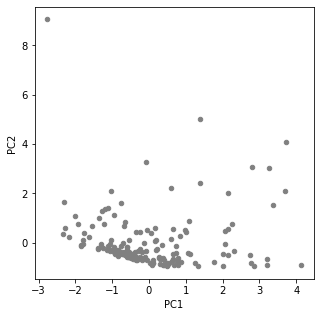

In [42]:
X_reduced.plot(x='PC1', y='PC2', kind='scatter', figsize=(5,5), color='gray')

#Nous avons représenté visuellement les points sur PC1 et PC2, maintenant la interessons nous à leur représentativité

## Realisation du Cercle de corrélation 

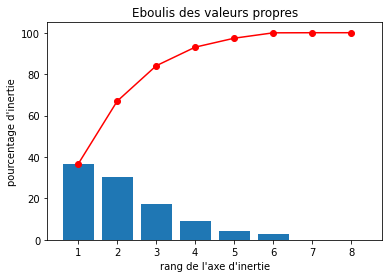

In [43]:
display_scree_plot(pca)

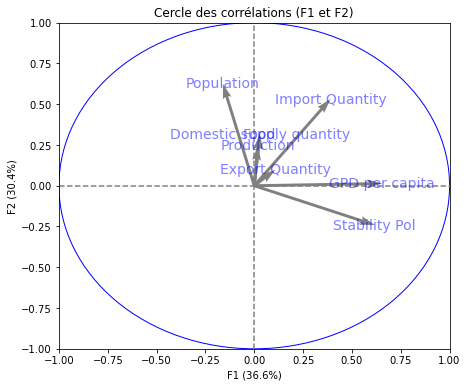

In [44]:
# Cercle des corrélations
features = X_scaled.columns
pcs = pca.components_
display_circles(pcs, 8, pca, [(0,1)], labels = np.array(features))

Nous pouvons observer que le PIB par hab et la stabilité politique sont corrélés à F1, et que l'Export, Production, Food, Domestique suply quantity sont corrélés à F2

On peut dire que F1 peut representer : " La prosperité du pays "
On peut dire que F2 peut representer : " Les besoins du pays "

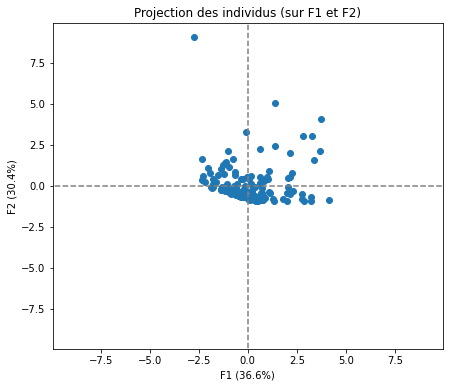

In [45]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, 8, pca, [(0,1)])

plt.show()


# KMeans

In [46]:
from sklearn.cluster import KMeans

In [47]:
from sklearn.preprocessing import MinMaxScaler

C:\Users\benmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


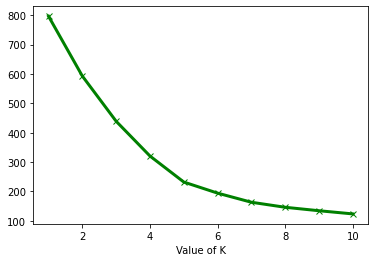

In [48]:
# Méthode Elbow 
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500, random_state = 0) 
    KM.fit(X_scaled) 
    cost.append(KM.inertia_)      
plt.plot(range(1, 11), cost, color ='g', linewidth ='3',marker="x") 
plt.xlabel("Value of K") 
plt.show() 

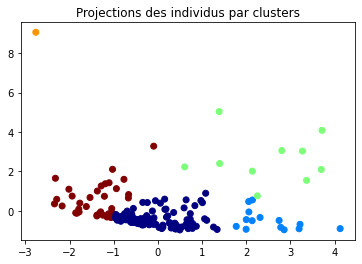

In [49]:
kmeans = KMeans(n_clusters= 5)
kmeans.fit(X_scaled.values)
X_scaled["Clusters"] = kmeans.labels_
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=X_scaled["Clusters"], cmap = 'jet')
plt.title("Projections des individus par clusters")
plt.show()

In [50]:
centroids = kmeans.cluster_centers_

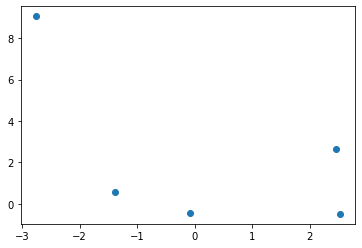

In [51]:
# Affichage des positions des centres de classes
plt.figure()
centroids = kmeans.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.show()

## Heatmap des clusters de la méthodes des kmeans

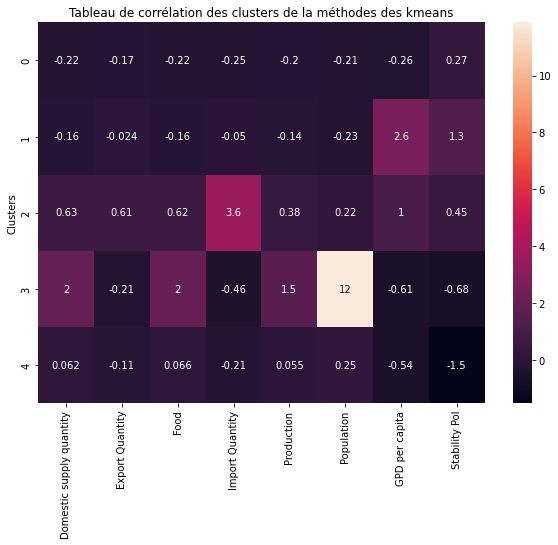

In [52]:
# Normalisation et groupe par les clusters 
f = X_scaled.groupby(["Clusters"]).mean()
plt.figure(figsize=(10,7))
sns.heatmap(f, annot = True)
plt.title("Tableau de corrélation des clusters de la méthodes des kmeans")
plt.show()

Ici la Heatmap nous aide énormement à savoir quel Cluster sur lequel nous devons investir
Le Cluser n°2 est très interessant car dans l'objectif de vendre de poulet l'un des aspects les plus importants à regarder 
est le "Import quantity" or nous avons un score de 3.6 (le plus élevé de tous). Par ailleurs les autres resultats sont tous positifs. Il semblerait que nous ayons trouvé notre groupe de pays

# Resultat des pays potentielles

In [56]:
df_final["Clusters"] = kmeans.labels_

In [57]:
pays_potentiel = df_final.loc[df_final['Clusters'] == 2]
pays_potentiel

,Area,Domestic supply quantity,Export Quantity,Food,Import Quantity,Production,Population,GPD per capita,Stability Pol,Clusters
31,"China, Hong Kong SAR",227000.00,663000.00,334000.00,907000.00,24000.00,7306322.00,46705.03,0.83,2
55,France,1563000.00,501000.00,1482000.00,506000.00,1750000.00,64842509.00,38720.65,0.28,2
59,Germany,1557000.00,646000.00,1492000.00,842000.00,1514000.00,82658409.00,44651.83,0.59,2
79,Japan,2415000.00,10000.00,2360000.00,1069000.00,2215000.00,127502725.00,38672.41,1.11,2
102,Mexico,4214000.00,9000.00,4214000.00,972000.00,3249000.00,124777324.00,9287.84,-0.72,2
110,Netherlands,289000.00,1418000.00,273000.00,608000.00,1099000.00,17021347.00,48989.64,0.92,2
136,Saudi Arabia,1258000.00,47000.00,1259000.00,744000.00,540000.00,33101179.00,20802.46,-0.58,2
144,South Africa,2110000.00,63000.00,2110000.00,514000.00,1665000.00,57009756.00,6121.88,-0.28,2
162,United Arab Emirates,492000.00,31000.00,246000.00,465000.00,57000.00,9487203.00,40644.80,0.62,2
163,United Kingdom of Great Britain and Northern I...,2275000.00,359000.00,2179000.00,779000.00,1839000.00,66727461.00,40448.37,0.33,2


In [58]:
pays_potentiel['Ratio'] = (pays_potentiel['Population'] / pays_potentiel['Import Quantity']) * pays_potentiel['Stability Pol']
pays_potentiel = pays_potentiel.sort_values(by="Ratio",ascending=False)
pays_potentiel

C:\Users\benmi\AppData\Local\Temp/ipykernel_12228/2363141682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pays_potentiel['Ratio'] = (pays_potentiel['Population'] / pays_potentiel['Import Quantity']) * pays_potentiel['Stability Pol']


,Area,Domestic supply quantity,Export Quantity,Food,Import Quantity,Production,Population,GPD per capita,Stability Pol,Clusters,Ratio
79,Japan,2415000.00,10000.00,2360000.00,1069000.00,2215000.00,127502725.00,38672.41,1.11,2,132.39
59,Germany,1557000.00,646000.00,1492000.00,842000.00,1514000.00,82658409.00,44651.83,0.59,2,57.92
55,France,1563000.00,501000.00,1482000.00,506000.00,1750000.00,64842509.00,38720.65,0.28,2,35.88
163,United Kingdom of Great Britain and Northern I...,2275000.00,359000.00,2179000.00,779000.00,1839000.00,66727461.00,40448.37,0.33,2,28.27
110,Netherlands,289000.00,1418000.00,273000.00,608000.00,1099000.00,17021347.00,48989.64,0.92,2,25.76
162,United Arab Emirates,492000.00,31000.00,246000.00,465000.00,57000.00,9487203.00,40644.80,0.62,2,12.65
31,"China, Hong Kong SAR",227000.00,663000.00,334000.00,907000.00,24000.00,7306322.00,46705.03,0.83,2,6.69
136,Saudi Arabia,1258000.00,47000.00,1259000.00,744000.00,540000.00,33101179.00,20802.46,-0.58,2,-25.80
144,South Africa,2110000.00,63000.00,2110000.00,514000.00,1665000.00,57009756.00,6121.88,-0.28,2,-31.06
102,Mexico,4214000.00,9000.00,4214000.00,972000.00,3249000.00,124777324.00,9287.84,-0.72,2,-92.43


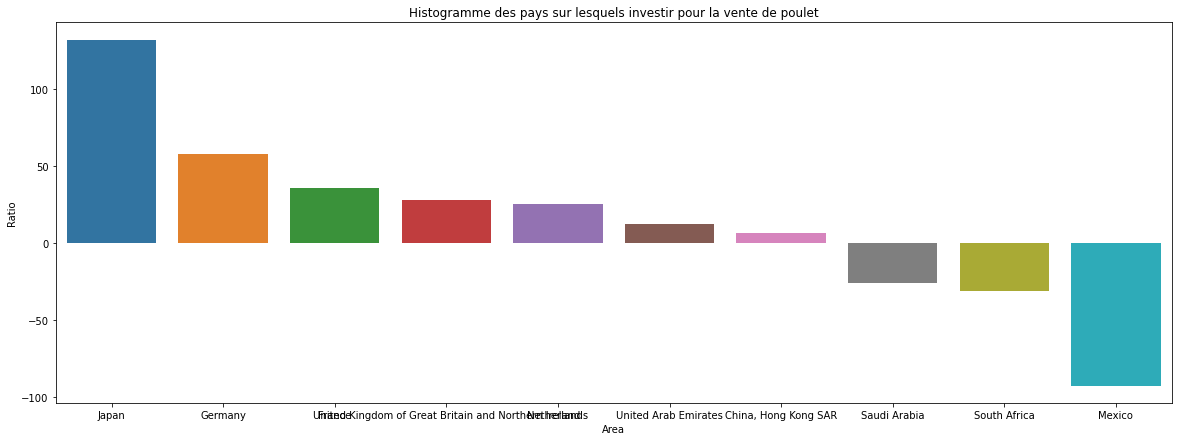

In [59]:
plt.figure(figsize= (20,7))
plt.title("Histogramme des pays sur lesquels investir pour la vente de poulet")
sns.barplot(x= "Area", y = "Ratio", data= pays_potentiel) 
plt.show()


In [60]:
#Pour terminer cette étude, nous pouvons nous pencher sur le Japon, l'Allemagne et la France comme pays potentiellement interessant pour l'exportation de Poulet.